# **Enhancing Momentum Investing with Skewness Filtering**

> Gianluca Licciardello, ID: 889935

> Stephen Adu Poku Yeboah, ID: 852121

> MSc Data Science – University of Milano-Bicocca

---
## **Abstract**

This project tests whether adding a simple skewness screen improves momentum investing in the S&P 500 index. We construct monthly Time-Series (TS), Cross-Sectional (CS), and Dual momentum portfolios (12–1 lookback, 1-month skip), apply lagged weights to avoid look-ahead, and compare them to the index. A skewness overlay keeps only stocks in the lowest rolling skewness quintile (36-month window, shifted by one month) before running the same momentum rules. We also analyze results within Small, Mid, and Large-cap buckets. Across the sample, skewness-enhanced portfolios generally deliver higher terminal wealth and higher Sharpe ratios than plain momentum, with the strongest gains in Small and Mid caps. Overall, skewness is a low-complexity enhancement that materially improves risk-adjusted momentum performance, especially outside mega-caps, subject to diversification, capacity, and trading-cost considerations.

---

## **Dataset: S\&P 500 (USA)**

The Standard and Poor's 500, or simply the S&P 500, is a stock market index tracking the stock performance of 500 leading companies listed on stock exchanges in the United States.

---

## **Strategies**

1. **Momentum**

- **Time-Series** (**TS**): Go long a stock if its own past return (12–1 lookback, 1-month skip) is ≥ 0; otherwise exclude.

- **Cross-Sectional** (**CS**): Rank all investable stocks by 12–1 momentum and hold the top 20% each month.

- **Dual**: Hold only stocks that pass both TS and CS at the same time.

2. **Momentum + Skewness**

- Before applying Momentum strategies, first keep only stocks in the lowest skewness quintile (Q1) using a 36-month rolling skewness, shifted by one month

- Then, run Momentum within that filtered set.

3. **Groups by Capitalization**

    Split the universe by index weight at each date:
    - **Small** (bottom 20%)
    - **Mid** (next 30%)
    - **Large** (top 50%).

---

## **Libraries**

Here are the libraries used for the project

In [106]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display, Markdown

In [107]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Loading Dataset**

**Observations**:

* The first row contains company names, this is not useful data. It has been excluded.
* The columns "data" or "Dates" have been renamed "Date", converted to datetime and chosen as an index.
* There is a considerable number of missing values (`NaN`), especially for stocks that entered the index later. These will require appropriate handling during the data-cleaning process.

In [108]:
file_path = '/content/gdrive/MyDrive/Data Science/Financial markets analytics/project/SPX500 Original.xlsm'
print('\n--- Loading Raw Data ---')
print('\n--- 1. Monthly Prices ---')
df_monthly = pd.read_excel(file_path, sheet_name="Price", header=1, index_col="data")
df_monthly.index.name = "Date"
df_monthly.index = pd.to_datetime(df_monthly.index)
display(df_monthly)
print('\n--- 2. Daily Prices ---')
df_daily = pd.read_excel(file_path, sheet_name="Price daily", header=1, index_col="Dates")
df_daily.index.name = "Date"
df_daily.index   = pd.to_datetime(df_daily.index)
display(df_daily)
print('\n--- 3. Weights ---')
df_weights = pd.read_excel(file_path, sheet_name="Peso", header=1, index_col="data")
df_weights.index.name  = "Date"
df_weights.index = pd.to_datetime(df_weights.index)
display(df_weights)


--- Loading Raw Data ---

--- 1. Monthly Prices ---


,3M Co,Abbott Laboratories,ACME-Cleveland Corp,Advanced Micro Devices Inc,AEP Texas Inc,Aeroquip-Vickers Inc,AIG Life Holdings Inc,Air Products & Chemicals Inc,Alberto-Culver Co,Albertson's LLC,...,Cboe Global Markets Inc.1,United Continental Holdings Inc.1,WellCare Health Plans Inc,Advanced Micro Devices Inc.2,Fortinet Inc,Linde PLC,Rollins Inc,Jack Henry & Associates Inc,Keysight Technologies Inc,Regency Centers Corp.1
Date,,,,,,,,,,,,,,,,,,,,,
1990-12-31,20.629,5.0348,4.750,2.4375,22.0000,18.2500,7.6875,12.6542,9.5408,18.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,1.2437,0.1250,NaN,NaN
1991-01-31,20.419,4.8810,5.375,3.5625,22.0000,22.0000,8.1875,13.6364,9.2897,19.3750,...,NaN,NaN,NaN,NaN,NaN,NaN,1.2144,0.1667,NaN,NaN
1991-02-28,21.291,5.1887,6.625,4.0625,22.0000,24.3750,9.1875,14.8499,8.8234,19.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,1.3242,0.2292,NaN,NaN
1991-03-29,21.291,5.3705,6.625,5.1875,22.5625,22.5000,9.6250,15.6588,8.5723,23.4375,...,NaN,NaN,NaN,NaN,NaN,NaN,1.4047,0.2500,NaN,NaN
1991-04-30,21.441,5.6642,6.500,6.1250,23.3750,22.1250,9.6875,14.4165,7.2452,23.9375,...,NaN,NaN,NaN,NaN,NaN,NaN,1.4120,0.2986,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-31,212.320,65.5400,30.000,18.3400,20.9375,57.9375,44.5500,164.1700,37.4900,25.6700,...,97.19,23.63,267.42,18.33,62.91,167.50,36.6267,134.7000,58.00,NaN
2018-08-31,210.920,66.8400,30.000,25.2000,20.9375,57.9375,44.5500,166.2900,37.4900,25.6700,...,100.77,23.63,302.57,25.17,83.76,158.19,40.0533,158.4400,64.89,NaN
2018-09-28,210.710,73.3600,30.000,30.8850,20.9375,57.9375,44.5500,167.0500,37.4900,25.6700,...,95.96,89.06,320.49,30.89,92.27,160.73,40.4600,160.0800,66.28,NaN



--- 2. Daily Prices ---


,3M Co,Abbott Laboratories,ACME-Cleveland Corp,Advanced Micro Devices Inc,AEP Texas Inc,Aeroquip-Vickers Inc,AIG Life Holdings Inc,Air Products & Chemicals Inc,Alberto-Culver Co,Albertson's LLC,...,Cboe Global Markets Inc.1,United Continental Holdings Inc.1,WellCare Health Plans Inc,Advanced Micro Devices Inc.2,Fortinet Inc,Linde PLC,Rollins Inc,Jack Henry & Associates Inc,Keysight Technologies Inc,Regency Centers Corp.1
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,19.366,3.874,11.000,4.1250,19.9375,24.5000,8.1875,11.4407,6.5279,14.0313,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0681,0.1007,NaN,NaN
1990-01-03,19.577,3.888,11.000,4.0000,20.0000,24.5000,8.1875,11.4407,6.6176,14.3750,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0681,0.1007,NaN,NaN
1990-01-04,19.727,3.881,11.375,3.9375,19.5625,24.6250,8.0938,11.2963,6.6534,14.4063,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0608,0.1007,NaN,NaN
1990-01-05,19.396,3.839,11.500,3.8125,19.0000,24.7500,8.1875,11.4407,6.7072,14.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0608,0.1042,NaN,NaN
1990-01-08,19.908,3.839,11.500,3.8125,19.3125,25.0000,8.2188,11.5563,6.8148,14.3125,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0535,0.0972,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,199.860,68.810,30.000,20.0800,20.9375,57.9375,44.5500,158.5800,37.4900,25.6700,...,107.27,91.75,245.96,20.08,70.84,157.32,40.7400,137.1100,58.53,62.58
2018-11-27,200.690,69.710,30.000,21.0300,20.9375,57.9375,44.5500,156.2700,37.4900,25.6700,...,107.93,93.38,243.07,21.05,70.70,152.55,41.1867,136.0200,59.40,62.64
2018-11-28,204.340,72.830,30.000,21.3300,20.9375,57.9375,44.5500,158.6600,37.4900,25.6700,...,106.24,94.48,251.82,21.34,73.52,156.29,42.3200,140.7500,61.50,62.87



--- 3. Weights ---


,3M Co,Abbott Laboratories,ACME-Cleveland Corp,Advanced Micro Devices Inc,AEP Texas Inc,Aeroquip-Vickers Inc,AIG Life Holdings Inc,Air Products & Chemicals Inc,Alberto-Culver Co,Albertson's LLC,...,Cboe Global Markets Inc.1,United Continental Holdings Inc.1,WellCare Health Plans Inc,Advanced Micro Devices Inc.2,Fortinet Inc,Linde PLC,Rollins Inc,Jack Henry & Associates Inc,Keysight Technologies Inc,Regency Centers Corp.1
Date,,,,,,,,,,,,,,,,,,,,,
1990-12-31,0.860680,0.889807,0.001362,0.018285,0.188649,0.023465,0.167493,0.138755,0.043176,0.222617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-31,0.817601,0.827890,0.001479,0.025648,0.181055,0.027147,0.171205,0.143506,0.040348,0.226825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.798521,0.824333,0.001707,0.027395,0.169586,0.028173,0.179947,0.146377,0.035895,0.211087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-29,0.779417,0.822729,0.001666,0.034145,0.169762,0.025384,0.183233,0.151489,0.033802,0.250666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.779417,0.822729,0.001666,0.034145,0.169762,0.025384,0.183233,0.151489,0.033802,0.250666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-31,0.528324,0.481596,NaN,NaN,NaN,NaN,NaN,0.150824,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-31,0.509038,0.476361,NaN,NaN,NaN,NaN,NaN,0.148172,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-28,0.502884,0.523599,NaN,NaN,NaN,NaN,NaN,0.149025,NaN,NaN,...,0.043655,0.082971,0.065163,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Check of the Data**

The datasets have been made free of survivor bias. There are securities that have missing periods, either because they had not yet joined the index or because they had already exited it. We checked this according to three rules:

1. **No Membership ⇒ No Imputation**\
At each month *t*, a stock is considered in the index only if its weight at *t* is greater than `0`. If it is not in the index, we leave its price as NA for that month and never fabricate returns.\
**Why?**\
Respects true index entry/exit, avoids survivorship bias and fake continuity.

2. **Within-Month Price Filling**\
If the monthly “Price” cell is missing, we fill it with the last available daily close in the same calendar month. If the whole month has no daily data, it stays `NaN`.\
**Why?**\
Useing only information available by month-end avoids forward/backward filling across months, which may introduce bias.

3. **Weights Hygiene**\
We do not interpolate weights through time. We simply convert `NaN` to `0` and clip negatives to `0`.\
**Why?**\
    - Keeps index membership explicit and honest
    - Prevents accidental inclusion due to filled weights
    - Ensures value-weighting can be re-normalized only over the actually tradable names.

In [109]:
# Safe copies + standardize indices
prices_m_sheet = df_monthly.copy()
daily_prices   = df_daily.copy()
weights_sheet  = df_weights.copy()

prices_m_sheet.index = pd.to_datetime(prices_m_sheet.index).to_period('M').to_timestamp('M')
weights_sheet.index  = pd.to_datetime(weights_sheet.index).to_period('M').to_timestamp('M')
daily_prices.index   = pd.to_datetime(daily_prices.index)

# Month-end from daily (last trading day of month)
prices_m_from_daily = daily_prices.sort_index().resample('M').last()

# Common grid (union of dates/columns)
all_cols = prices_m_sheet.columns.union(prices_m_from_daily.columns).union(weights_sheet.columns)
all_idx  = prices_m_sheet.index.union(prices_m_from_daily.index).union(weights_sheet.index)

m_sheet_aligned = prices_m_sheet.reindex(index=all_idx, columns=all_cols)
m_fromd_aligned = prices_m_from_daily.reindex(index=all_idx, columns=all_cols)
weights_aligned = weights_sheet.reindex(index=all_idx, columns=all_cols)

# Rule #2: monthly <- daily fallback where monthly missing but daily available
fallback_used_mask       = m_sheet_aligned.isna() & m_fromd_aligned.notna()
rule2_fill_count_total   = int(fallback_used_mask.values.sum())
prices_m_raw             = m_sheet_aligned.combine_first(m_fromd_aligned)

# Rule #3: weights NaN->0; negatives->0
rule3_nan_to_zero        = int(weights_aligned.isna().values.sum())
rule3_neg_to_zero        = int((weights_aligned.fillna(0) < 0).values.sum())
weights_clean            = weights_aligned.fillna(0.0).clip(lower=0.0)

# Rule #1: membership = weights > 0; mask prices outside the index
membership               = (weights_clean > 0)
rule1_masked_prices      = int(((~membership) & prices_m_raw.notna()).values.sum())
prices_m                 = prices_m_raw.where(membership)

# Fallbacks kept/dropped after applying membership
fallback_kept            = int((fallback_used_mask & membership).values.sum())
fallback_dropped         = int((fallback_used_mask & (~membership)).values.sum())

# Diagnostic: in-index cells that still lack a price (no monthly & no daily that month)
unpriced_in_index        = int((membership & prices_m.isna()).values.sum())

# Summary table only
summary = pd.DataFrame(
    {
        "Rule #1 masked (out-of-index price cells)": [rule1_masked_prices],
        "Rule #2 filled from daily (total)"        : [rule2_fill_count_total],
        "Rule #2 fallbacks kept (in-index)"        : [fallback_kept],
        "Rule #2 fallbacks dropped (out-of-index)" : [fallback_dropped],
        "Rule #3 weights NaN -> 0"                 : [rule3_nan_to_zero],
        "Rule #3 weights <0 -> 0"                  : [rule3_neg_to_zero],
        "Diag: in-index cells with NO price"       : [unpriced_in_index],
    }
).T.rename(columns={0: "count"}).astype(int)

display(summary)

/tmp/ipython-input-641034974.py:11: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



,count
Rule #1 masked (out-of-index price cells),229334
Rule #2 filled from daily (total),8253
Rule #2 fallbacks kept (in-index),0
Rule #2 fallbacks dropped (out-of-index),8253
Rule #3 weights NaN -> 0,301978
Rule #3 weights <0 -> 0,0
Diag: in-index cells with NO price,0


In [110]:
def _fmt_dates(idx):
    # Return list of strings in 'YYYY-MM-DD'
    if isinstance(idx, pd.DatetimeIndex):
        return idx.strftime('%Y-%m-%d').tolist()
    try:
        di = pd.to_datetime(idx, errors='coerce')
        if getattr(di, "notna", None) is not None and di.notna().all():
            return di.strftime('%Y-%m-%d').tolist()
    except Exception:
        pass
    # Fallback: trim to first 10 chars
    return [str(x)[:10] for x in idx]

print('\n--- Data after Checks ---')

print('\n--- 1. Monthly Prices ---')
monthly_checked = prices_m.reindex(columns=df_monthly.columns)

# (a) drop all-NaN rows
mn_allnan_rows = monthly_checked.index[monthly_checked.isna().all(axis=1)]
if len(mn_allnan_rows) > 0:
    print(f"\nDropping {len(mn_allnan_rows)} all-NaN rows:")
    print(_fmt_dates(mn_allnan_rows))
    monthly_checked = monthly_checked.drop(index=mn_allnan_rows)
else:
    print("\nNo all-NaNrows found.")

# (b) drop all-NaN columns
mn_allnan_cols = monthly_checked.columns[monthly_checked.isna().all(axis=0)]
if len(mn_allnan_cols) > 0:
    print(f"\nRemoved {len(mn_allnan_cols)} all-NaN columns: {list(mn_allnan_cols)}")
    monthly_checked = monthly_checked.drop(columns=mn_allnan_cols)
else:
    print("\nNo all-NaN columns found.")

display(monthly_checked)

print('\n--- 2. Daily Prices ---')

# (a) dropped all-NaN rows
dy_allnan_rows = df_daily.index[df_daily.isna().all(axis=1)]
if len(dy_allnan_rows) > 0:
    print(f"\nDropping {len(dy_allnan_rows)} all-NaN rows:")
    print(_fmt_dates(dy_allnan_rows))
    df_daily = df_daily.drop(index=dy_allnan_rows)
else:
    print("\nNo all-NaN rows found.")

# (b) drop all-NaN columns
dy_allnan_cols = df_daily.columns[df_daily.isna().all(axis=0)]
if len(dy_allnan_cols) > 0:
    print(f"\nRemoved {len(dy_allnan_cols)} all-NaN columns: {list(dy_allnan_cols)}")
    df_daily = df_daily.drop(columns=dy_allnan_cols)
else:
    print("\nNo all-NaN columns found.")

display(df_daily)

print('\n--- 3. Weights ---')

weights_checked = weights_clean.reindex(columns=df_weights.columns)

# (a) drop all-zero rows
wt_allzero_rows = weights_checked.index[(weights_checked == 0).all(axis=1)]
if len(wt_allzero_rows) > 0:
    print(f"\nDropping {len(wt_allzero_rows)} all-zero rows:")
    print(_fmt_dates(wt_allzero_rows))
    weights_checked = weights_checked.drop(index=wt_allzero_rows)
else:
    print("\nNo all-zero rows found.")

# (b) drop all-zero columns
wt_allzero_cols = weights_checked.columns[(weights_checked.fillna(0) == 0).all(axis=0)]
if len(wt_allzero_cols) > 0:
    print(f"\nRemoved {len(wt_allzero_cols)} all-zero columns: {list(wt_allzero_cols)}")
    weights_checked = weights_checked.drop(columns=wt_allzero_cols)
else:
    print("\nNo all-zero weight columns found.")

# (c) drop all-NaN columns too
wt_allnan_cols = weights_checked.columns[weights_checked.isna().all(axis=0)]
if len(wt_allnan_cols) > 0:
    print(f"\nRemoved {len(wt_allnan_cols)} all-NaN columns: {list(wt_allnan_cols)}")
    weights_checked = weights_checked.drop(columns=wt_allnan_cols)

display(weights_checked)


--- Data after Checks ---

--- 1. Monthly Prices ---

Dropping 11 all-NaN rows:
['1990-01-31', '1990-02-28', '1990-03-31', '1990-04-30', '1990-05-31', '1990-06-30', '1990-07-31', '1990-08-31', '1990-09-30', '1990-10-31', '1990-11-30']

Removed 1 all-NaN columns: ['Global Crossing Ltd/Old']


,3M Co,Abbott Laboratories,ACME-Cleveland Corp,Advanced Micro Devices Inc,AEP Texas Inc,Aeroquip-Vickers Inc,AIG Life Holdings Inc,Air Products & Chemicals Inc,Alberto-Culver Co,Albertson's LLC,...,Cboe Global Markets Inc.1,United Continental Holdings Inc.1,WellCare Health Plans Inc,Advanced Micro Devices Inc.2,Fortinet Inc,Linde PLC,Rollins Inc,Jack Henry & Associates Inc,Keysight Technologies Inc,Regency Centers Corp.1
Date,,,,,,,,,,,,,,,,,,,,,
1990-12-31,20.629,5.0348,4.750,2.4375,22.0000,18.250,7.6875,12.6542,9.5408,18.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-31,20.419,4.8810,5.375,3.5625,22.0000,22.000,8.1875,13.6364,9.2897,19.3750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,21.291,5.1887,6.625,4.0625,22.0000,24.375,9.1875,14.8499,8.8234,19.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,21.291,5.3705,6.625,5.1875,22.5625,22.500,9.6250,15.6588,8.5723,23.4375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,21.441,5.6642,6.500,6.1250,23.3750,22.125,9.6875,14.4165,7.2452,23.9375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-31,212.320,65.5400,NaN,NaN,NaN,NaN,NaN,164.1700,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-31,210.920,66.8400,NaN,NaN,NaN,NaN,NaN,166.2900,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30,210.710,73.3600,NaN,NaN,NaN,NaN,NaN,167.0500,NaN,NaN,...,95.96,89.06,320.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN



--- 2. Daily Prices ---

No all-NaN rows found.

No all-NaN columns found.


,3M Co,Abbott Laboratories,ACME-Cleveland Corp,Advanced Micro Devices Inc,AEP Texas Inc,Aeroquip-Vickers Inc,AIG Life Holdings Inc,Air Products & Chemicals Inc,Alberto-Culver Co,Albertson's LLC,...,Cboe Global Markets Inc.1,United Continental Holdings Inc.1,WellCare Health Plans Inc,Advanced Micro Devices Inc.2,Fortinet Inc,Linde PLC,Rollins Inc,Jack Henry & Associates Inc,Keysight Technologies Inc,Regency Centers Corp.1
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,19.366,3.874,11.000,4.1250,19.9375,24.5000,8.1875,11.4407,6.5279,14.0313,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0681,0.1007,NaN,NaN
1990-01-03,19.577,3.888,11.000,4.0000,20.0000,24.5000,8.1875,11.4407,6.6176,14.3750,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0681,0.1007,NaN,NaN
1990-01-04,19.727,3.881,11.375,3.9375,19.5625,24.6250,8.0938,11.2963,6.6534,14.4063,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0608,0.1007,NaN,NaN
1990-01-05,19.396,3.839,11.500,3.8125,19.0000,24.7500,8.1875,11.4407,6.7072,14.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0608,0.1042,NaN,NaN
1990-01-08,19.908,3.839,11.500,3.8125,19.3125,25.0000,8.2188,11.5563,6.8148,14.3125,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0535,0.0972,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,199.860,68.810,30.000,20.0800,20.9375,57.9375,44.5500,158.5800,37.4900,25.6700,...,107.27,91.75,245.96,20.08,70.84,157.32,40.7400,137.1100,58.53,62.58
2018-11-27,200.690,69.710,30.000,21.0300,20.9375,57.9375,44.5500,156.2700,37.4900,25.6700,...,107.93,93.38,243.07,21.05,70.70,152.55,41.1867,136.0200,59.40,62.64
2018-11-28,204.340,72.830,30.000,21.3300,20.9375,57.9375,44.5500,158.6600,37.4900,25.6700,...,106.24,94.48,251.82,21.34,73.52,156.29,42.3200,140.7500,61.50,62.87



--- 3. Weights ---

Dropping 11 all-zero rows:
['1990-01-31', '1990-02-28', '1990-03-31', '1990-04-30', '1990-05-31', '1990-06-30', '1990-07-31', '1990-08-31', '1990-09-30', '1990-10-31', '1990-11-30']

Removed 1 all-zero columns: ['Global Crossing Ltd/Old']


,3M Co,Abbott Laboratories,ACME-Cleveland Corp,Advanced Micro Devices Inc,AEP Texas Inc,Aeroquip-Vickers Inc,AIG Life Holdings Inc,Air Products & Chemicals Inc,Alberto-Culver Co,Albertson's LLC,...,Cboe Global Markets Inc.1,United Continental Holdings Inc.1,WellCare Health Plans Inc,Advanced Micro Devices Inc.2,Fortinet Inc,Linde PLC,Rollins Inc,Jack Henry & Associates Inc,Keysight Technologies Inc,Regency Centers Corp.1
Date,,,,,,,,,,,,,,,,,,,,,
1990-12-31,0.860680,0.889807,0.001362,0.018285,0.188649,0.023465,0.167493,0.138755,0.043176,0.222617,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1991-01-31,0.817601,0.827890,0.001479,0.025648,0.181055,0.027147,0.171205,0.143506,0.040348,0.226825,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1991-02-28,0.798521,0.824333,0.001707,0.027395,0.169586,0.028173,0.179947,0.146377,0.035895,0.211087,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1991-03-31,0.779417,0.822729,0.001666,0.034145,0.169762,0.025384,0.183233,0.151489,0.033802,0.250666,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1991-04-30,0.779417,0.822729,0.001666,0.034145,0.169762,0.025384,0.183233,0.151489,0.033802,0.250666,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-31,0.528324,0.481596,0.000000,0.000000,0.000000,0.000000,0.000000,0.150824,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-08-31,0.509038,0.476361,0.000000,0.000000,0.000000,0.000000,0.000000,0.148172,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-09-30,0.502884,0.523599,0.000000,0.000000,0.000000,0.000000,0.000000,0.149025,0.000000,0.000000,...,0.043655,0.082971,0.065163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [111]:
file_path = "/content/gdrive/MyDrive/Data Science/Financial markets analytics/project/monthly_checked.csv"
monthly_checked.to_csv(file_path, index=True)
file_path = "/content/gdrive/MyDrive/Data Science/Financial markets analytics/project/weights_checked.csv"
weights_checked.to_csv(file_path, index=True)

## **Stocks History and Index Capacity Check**

In [112]:
# 1. Count non-NaN monthly data for each stock
non_nan_counts = monthly_checked.count().sort_values()

# 2. First 10 (shortest history) and last 10 (longest history)
shortest_10 = non_nan_counts.head(10)
longest_10 = non_nan_counts.tail(10)

print("Stocks with the longest histories:")
print(longest_10)
print("\nStocks with the shortest histories:")
print(shortest_10)

# 3. Total number of missing values
total_missing = monthly_checked.isna().sum().sum()
print(f"\nTotal missing values in monthly prices: {total_missing:,}")

Stocks with the longest histories:
Bank of America Corp              336
Baxter International Inc          336
General Electric Co               336
General Mills Inc                 336
Genuine Parts Co                  336
FedEx Corp                        336
American Electric Power Co Inc    336
Abbott Laboratories               336
3M Co                             336
American Express Co               336
dtype: int64

Stocks with the shortest histories:
Regency Centers Corp.1         1
Keysight Technologies Inc      1
Jack Henry & Associates Inc    1
Adient PLC                     1
Mattel Inc.1                   1
Juniper Networks Inc           1
Bay Networks Inc               1
PAN AM Corp                    1
Andeavor.1                     1
Rollins Inc                    2
dtype: int64

Total missing values in monthly prices: 286,737


In [113]:
# Count available monthly prices per date
counts = monthly_checked.notna().sum(axis=1).sort_index()

# Keep only dates where at least one stock has data (prevents trailing empty years)
counts = counts[counts > 0]

# Make sure the index is datetime (safer for Plotly)
counts.index = pd.to_datetime(counts.index)

total_stocks = monthly_checked.shape[1]

fig = go.Figure(go.Scatter(
    x=counts.index,
    y=counts.values,
    mode='lines',
    name='Available stocks (monthly)'
))

fig.update_layout(
    title=f'Number of Stocks with Available Monthly Prices — Total Universe: {total_stocks}',
    xaxis_title='Month',
    yaxis_title='Count of Stocks',
    hovermode='x unified',
    xaxis=dict(
        rangeslider=dict(visible=True),
        rangeselector=dict(
            buttons=[
                dict(count=12, label='1Y', step='month', stepmode='backward'),
                dict(count=36, label='3Y', step='month', stepmode='backward'),
                dict(count=60, label='5Y', step='month', stepmode='backward'),
                dict(step='all', label='All')
            ]
        )
    ),
    template='plotly_white'
)

# Force the x-axis to end exactly at the last date with data (e.g., 2018-12)
fig.update_xaxes(range=[counts.index.min(), counts.index.max()])

fig.show()

We observe that the index contains **500** assets almost every time until March 2014, except from August 1999 to November 2000. After March 2014, the index reaches **505** assets, with peaks of **506** in November 2015 and October 2016.

## **Building Portfolios**

### **1. Setting the Environment**

- Building the Universe
- Calculating Monthly Returns

In [114]:

def prep(prices, weights):
    # month-end, sorted, common index/columns
    prices = prices.copy()
    weights = weights.copy()
    prices.index  = pd.to_datetime(prices.index).to_period('M').to_timestamp('M')
    weights.index = pd.to_datetime(weights.index).to_period('M').to_timestamp('M')
    prices  = prices.sort_index()
    weights = weights.sort_index()

    common_idx  = prices.index.intersection(weights.index)
    common_cols = prices.columns.intersection(weights.columns)
    P = prices.reindex(index=common_idx, columns=common_cols)
    W = weights.reindex(index=common_idx, columns=common_cols)

    # investable universe each month (weight > 0)
    U = (W > 0)

    # monthly returns for PnL (no fill/pad, end-of-month labeling)
    R = P.pct_change(fill_method=None)

    return P, W, U, R

### **2. Momentum and Availability Check**

Momentum formula: $M_t = \frac{P_{t-1}}{P_{t-12}} - 1$

Observed months: $k = 12$

Latest month excluded $j = 1$

In [115]:
def momentum_k_j(prices: pd.DataFrame, k=12, j=1, mode="trend"):
    """
    mode='trend'  : M_t = P_{t-j}/P_{t-k} - 1  (positive when price rose)
    mode='contra' : M_t = P_{t-k}/P_{t-j} - 1  (positive when price fell)
    """
    if mode == "trend":
        return prices.shift(j) / prices.shift(k) - 1
    elif mode == "contra":
        return prices.shift(k) / prices.shift(j) - 1
    else:
        raise ValueError("mode must be 'trend' or 'contra'")

def availability_k_j(prices: pd.DataFrame, k=12, j=1):
    """Asset eligible at t only if P_{t-j} and P_{t-k} exist."""
    return prices.shift(j).notna() & prices.shift(k).notna()

### **3. Momentum Strategies**

1. **Time-Series** (TS):
- Threshold: positive returns ($r > 0$)

2. **Cross-Sectional** (CS):
- Threshold: second deciles (Top 20% returns)

3. **Dual**:
- Intersection of the two previous strategies

In [116]:
def ts_mask(momentum: pd.DataFrame, universe: pd.DataFrame, availability: pd.DataFrame, threshold=0.00):
    # TS: momentum >= threshold within investable+available
    return (momentum >= threshold) & universe & availability

def cs_mask(momentum: pd.DataFrame, universe: pd.DataFrame, availability: pd.DataFrame, top_frac=0.20):
    # CS: top X% within investable+available
    scope = universe & availability
    ranks = momentum.where(scope).rank(axis=1, method='first', ascending=False, pct=True)
    return ranks <= top_frac

def dual_mask(momentum, universe, availability, threshold=0.00, top_frac=0.20):
    return ts_mask(momentum, universe, availability, threshold) & cs_mask(momentum, universe, availability, top_frac)

### **4. Weights Choice**

- Proportional to the original index's weights

  Given (at month t):
  - $w_{i,t}$ = original index weight of asset i (in %-points; rows sum ≈ 100)
  - $m_{i,t}$ = selection mask ∈ {0,1} (1 if asset i is selected at t, else 0)
  - $f_{i,t}$ = fallback weights (e.g., benchmark original weights at t)

  1. **Pre-selection** (zero out unselected names):\
  $~w_{i,t} = m_{i,t} · w_{i,t}$

  2. **Row sum of selected weights**:\
  $S_t = Σ_i ~w_{i,t}$

  3. **Reweighted portfolio** (sum to 100):\
  **If** $S_t > 0:$\
    $w_{i,t} = \frac{~w_{i,t}}{S_t} · 100$\
  **Else** (no asset selected):\
    $w_{i,t} = f_{i,t}$


- Benchmark's weights as in the original data

In [117]:
def reweight_to_100_with_fallback(weights: pd.DataFrame, select_mask: pd.DataFrame, fallback_weights: pd.DataFrame):
    """
    If no asset is selected in a month, use fallback (e.g., benchmark original weights) for that month.
    Otherwise, keep only selected names and renormalize to 100.
    """
    sel = weights.where(select_mask, 0.0)
    row_sum = sel.sum(axis=1)
    reweighted = sel.div(row_sum.where(row_sum != 0), axis=0).mul(100.0)
    # rows with no selection -> fallback (already sums ~100)
    empty = row_sum.eq(0)
    if empty.any():
        reweighted.loc[empty] = fallback_weights.loc[empty]
    return reweighted.fillna(0.0)

### **5. Portfolio returns estimation**

Portfolio return at time t (using previous month’s weights):\
$r_{p,t} = \frac{1}{100} Σ_i  w_{i,t-1} · r_{i,t}$

Where:
- $w_{i,t-1}$  = portfolio weight (in percentage points) of asset i decided at t−1
- $r_{i,t}$    = asset i return over (t−1 → t)


In [118]:
# --- 4) Portfolio returns (lag weights to avoid look-ahead) ---
def portfolio_returns(weights_percent: pd.DataFrame, returns: pd.DataFrame, lag: int = 1) -> pd.Series:
    """
    Use lag=1 (default) to apply previous month's weights to current returns (no look-ahead).
    """
    Wlag = weights_percent.shift(lag)
    return (Wlag * returns).sum(axis=1) / 100.0

### **6. Investment Curves**

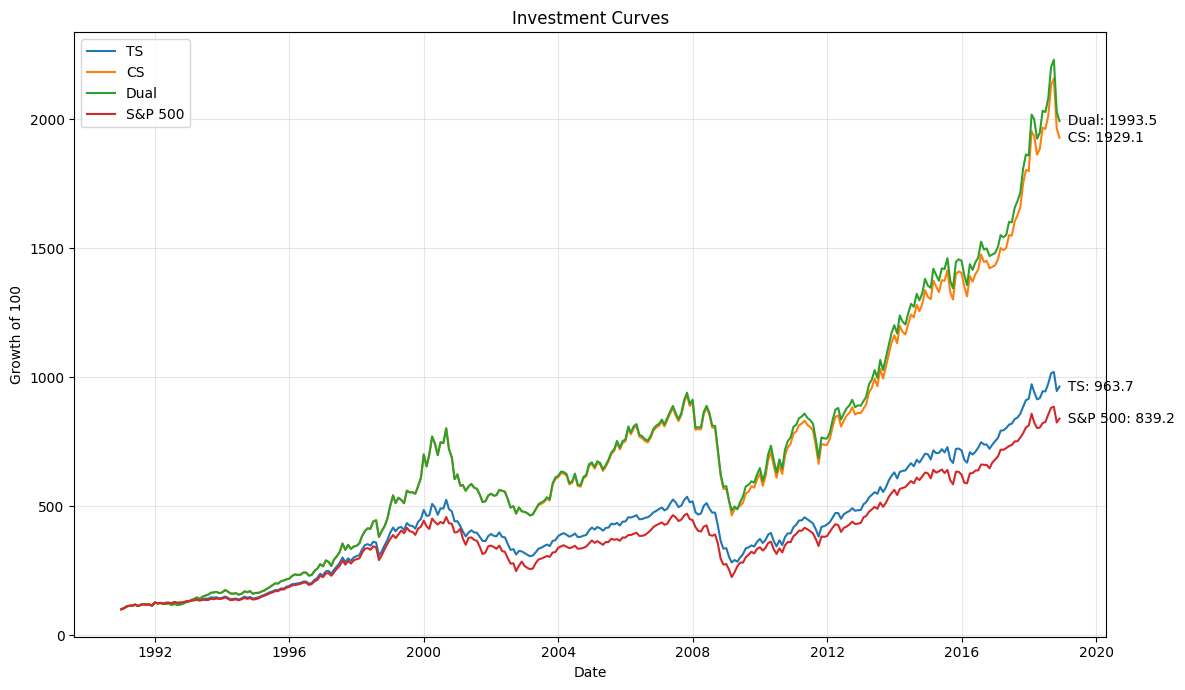

In [119]:
# --- 5) Plot investment curves ---
def plot_investment_curves(returns_dict, base=100.0, logy=False, title="Investment (Equity) Curves"):
    """
    returns_dict: {"label": pd.Series_of_monthly_returns, ...}
    """
    # align to common dates where ALL series are available
    df_ret = pd.concat(returns_dict, axis=1)
    df_ret.columns = [c if isinstance(c, str) else c[0] for c in df_ret.columns]
    df_ret = df_ret.dropna(how="any")  # same start for fair comparison

    # build equity curves
    eq = base * (1 + df_ret).cumprod()

    # plot
    plt.figure(figsize=(12, 7))
    for col in eq.columns:
        plt.plot(eq.index, eq[col], label=col)
        y_last = eq[col].iloc[-1]
        plt.text(eq.index[-1], y_last, f"  {col}: {y_last:.1f}", va='center')
    plt.title(title); plt.xlabel("Date"); plt.ylabel(f"Growth of {int(base)}")
    if logy:
        plt.yscale("log")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

# ================== USAGE ==================
# 0) Inputs: monthly_checked (prices), weights_checked (weights)
P, W, U, R = prep(monthly_checked, weights_checked)

# 1) Momentum & availability (trend 12–1)
M  = momentum_k_j(P, k=12, j=1, mode="trend")
AV = availability_k_j(P, k=12, j=1)

# 2) Selections (looser gates)
TS_sel   = ts_mask(M, U, AV, threshold=0.00)   # TS ≥ 0%
CS_sel   = cs_mask(M, U, AV, top_frac=0.20)    # CS top 20%
DUAL_sel = dual_mask(M, U, AV, threshold=0.00, top_frac=0.20)

# 3) Strategy weights (sum 100) with fallback to benchmark if empty
W_BENCH_ORIG = W                                # benchmark = original weights (already sum to 100)
W_TS   = reweight_to_100_with_fallback(W, TS_sel,   W_BENCH_ORIG)
W_CS   = reweight_to_100_with_fallback(W, CS_sel,   W_BENCH_ORIG)
W_DUAL = reweight_to_100_with_fallback(W, DUAL_sel, W_BENCH_ORIG)

# 4) Returns (lag=1 to avoid look-ahead)
r_TS   = portfolio_returns(W_TS,          R, lag=1)
r_CS   = portfolio_returns(W_CS,          R, lag=1)
r_DUAL = portfolio_returns(W_DUAL,        R, lag=1)
r_BEN  = portfolio_returns(W_BENCH_ORIG,  R, lag=1)

# 5) Single final plot (remove any earlier "example" plot calls)
plot_investment_curves(
    {
        "TS": r_TS,
        "CS": r_CS,
        "Dual": r_DUAL,
        "S&P 500": r_BEN
    },
    base=100.0,
    logy=False,
    title="Investment Curves"
)

The growth of a $100 investment by the end, reaches ≈1,993.5× for **Dual** and ≈1,929.1× for **CS**, both handily beat **TS** (≈954×) and the **Benchmark** (≈8.39×). Dual edges CS most of the way after 2009.

### **7. Holdings per month**

In [120]:
# ------- holdings counter (weights > 0) -------
def track_holdings(weights_df: pd.DataFrame) -> pd.Series:
    """Count how many assets have strictly positive weights each month."""
    return weights_df.gt(0).sum(axis=1).astype(int)

# --- holdings time series ---
ts_holdings        = track_holdings(W_TS)
cs_holdings        = track_holdings(W_CS)
dual_holdings      = track_holdings(W_DUAL)
benchmark_holdings = track_holdings(W_BENCH_ORIG)  # benchmark = original weights

# --- selection counts (non-fallback months are those with count > 0) ---
ts_sel_count   = TS_sel.sum(axis=1)
cs_sel_count   = CS_sel.sum(axis=1)
dual_sel_count = DUAL_sel.sum(axis=1)

mask_ts_live   = ts_sel_count > 0
mask_cs_live   = cs_sel_count > 0
mask_dual_live = dual_sel_count > 0

# Align all dates and build a tidy DataFrame (for display)
holdings_df = pd.concat(
    {
        "TS": ts_holdings,
        "CS": cs_holdings,
        "Dual": dual_holdings,
        "S&P 500": benchmark_holdings
    },
    axis=1
).sort_index()

# Pick the first date where ALL strategies are actually live (selected ≥1 asset)
mask_all_live = mask_ts_live & mask_cs_live & mask_dual_live
if mask_all_live.any():
    first_valid_date = mask_all_live.idxmax()
    holdings_df_filtered = holdings_df.loc[first_valid_date:].copy()
else:
    holdings_df_filtered = holdings_df.copy()

# ---- averages: exclude fallback months for each strategy individually ----
avg_ts   = ts_holdings.loc[mask_ts_live].mean() if mask_ts_live.any() else np.nan
avg_cs   = cs_holdings.loc[mask_cs_live].mean() if mask_cs_live.any() else np.nan
avg_dual = dual_holdings.loc[mask_dual_live].mean() if mask_dual_live.any() else np.nan
avg_bm   = benchmark_holdings.mean()  # benchmark has no fallback condition

avg_counts = {
    "TS": round(avg_ts, 2),
    "CS": round(avg_cs, 2),
    "Dual": round(avg_dual, 2),
    "S&P 500": round(avg_bm, 2)
}

# Append averages to column names
holdings_df_filtered = holdings_df_filtered.rename(
    columns={col: f"{col} ({avg_counts[col]} assets)" for col in holdings_df_filtered.columns}
)

# Show table (Date as a column)
holdings_table = holdings_df_filtered.reset_index().rename(columns={"index": "Date"})
display(holdings_table)

# Save CSV (Colab/Drive path)
file_path = "/content/gdrive/MyDrive/Data Science/Financial markets analytics/project/number_of_holdings.csv"
holdings_table.to_csv(file_path, index=False)
print(f"Saved to: {file_path}")

,Date,TS (298.53 assets),CS (93.49 assets),Dual (91.0 assets),S&P 500 (500.62 assets)
0,1991-12-31,344,97,97,500
1,1992-01-31,365,96,96,500
2,1992-02-29,333,96,96,500
3,1992-03-31,332,96,96,500
4,1992-04-30,326,96,96,500
...,...,...,...,...,...
319,2018-07-31,309,96,96,505
320,2018-08-31,346,96,96,505
321,2018-09-30,336,96,96,505
322,2018-10-31,315,96,96,505


Saved to: /content/gdrive/MyDrive/Data Science/Financial markets analytics/project/number_of_holdings.csv


### **8. Statistics**

The following statistics are shown in the table:

1. **Average Monthly Return** (%): average of the monthly % returns.\
**Formula**: $E(r) = \frac{1}{T}Σ_{t=1..T} r_t$

2. **Monthly Volatility** (%): standard deviation of monthly returns.\
**Formula**: $\sigma_r = \sqrt{\frac{1}{T-1}Σ_{t=1..T} (r_t - E(r))^2}$

3. **Monthly Sharpe**: average monthly excess return divided by monthly volatility (risk-free to 0).\
**Formula**: $Sharpe Ratio = \frac{E(r)}{\sigma_r}$

4. **Max Drawdown** (%): the worst peak-to-trough loss on the equity curve.
  
    **Formula**:

    - $Peak_t = max(r_0, r_1, ..., r_T)$
    - $DD_t   = (E_t / Peak_t) - 1$
    - $MaxDD  = min_t DD_t$

5. **Win Rate** (%): % of months with a positive return.\
**Formula**: $Win Rate = \frac{Postive Return Months}{T} \times 100$

In [121]:
def equity_curve(returns: pd.Series) -> pd.Series:

    r = returns.dropna()
    if r.empty:
        return pd.Series(dtype=float)
    return (1 + r).cumprod()

# Build equity curves for each strategy/benchmark
eq_TS   = equity_curve(r_TS)
eq_CS   = equity_curve(r_CS)
eq_DUAL = equity_curve(r_DUAL)
eq_BEN  = equity_curve(r_BEN)

def calculate_monthly_metrics(equity: pd.Series,
                              returns: pd.Series,
                              rf_annual: float = 0.0):

    if equity.empty:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    # align and clean
    r = returns.loc[equity.index].dropna()
    if r.empty:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    avg_m   = r.mean()
    vol_m   = r.std()
    rf_m    = (1 + rf_annual) ** (1/12) - 1
    sharpe_m = (avg_m - rf_m) / vol_m if vol_m and vol_m > 0 else np.nan

    # max drawdown from equity curve
    roll_max = equity.cummax()
    drawdown = equity / roll_max - 1
    max_dd   = drawdown.min()

    win_rate = (r > 0).mean() * 100.0

    return avg_m, vol_m, sharpe_m, max_dd, win_rate

# ---- collect metrics for all portfolios (only the 5 stats) ----
metrics = {}
for label, eq, ret in [
    ("TS",                        eq_TS,   r_TS),
    ("CS",                        eq_CS,   r_CS),
    ("Dual",                      eq_DUAL, r_DUAL),
    ("S&P 500", eq_BEN,  r_BEN),
]:
    avg_m, vol_m, sharpe_m, max_dd, win_rate = calculate_monthly_metrics(eq, ret, rf_annual=0.0)
    metrics[label] = {
        "Average Monthly Return (%)":  100 * avg_m,
        "Monthly Volatility (%)":  100 * vol_m,
        "Monthly Sharpe":          sharpe_m,
        "Max Drawdown (%)":        100 * max_dd,
        "Win Rate (%)":            win_rate,
    }

# Nicely formatted summary table (5 stats only)
summary_table_m = pd.DataFrame(metrics).T
summary_table_m = summary_table_m[[
    "Average Monthly Return (%)",
    "Monthly Volatility (%)",
    "Monthly Sharpe",
    "Max Drawdown (%)",
    "Win Rate (%)"
]].round({
    "Average Monthly Return (%)": 2,
    "Monthly Volatility (%)": 2,
    "Monthly Sharpe": 3,
    "Max Drawdown (%)": 2,
    "Win Rate (%)": 2
})

display(summary_table_m)

,Average Monthly Return (%),Monthly Volatility (%),Monthly Sharpe,Max Drawdown (%),Win Rate (%)
TS,0.75,3.77,0.198,-47.48,64.88
CS,0.99,4.49,0.219,-50.17,62.50
Dual,1.00,4.49,0.222,-48.62,62.50
S&P 500,0.72,4.01,0.179,-52.25,64.29


## **Skewness Improvements**

### **1. Recalling Previous Function**

In [122]:
# ---------- 0) PREP ----------
def prep(prices, weights):
    prices = prices.copy(); weights = weights.copy()
    prices.index  = pd.to_datetime(prices.index).to_period('M').to_timestamp('M')
    weights.index = pd.to_datetime(weights.index).to_period('M').to_timestamp('M')
    prices  = prices.sort_index(); weights = weights.sort_index()
    common_idx  = prices.index.intersection(weights.index)
    common_cols = prices.columns.intersection(weights.columns)
    P = prices.reindex(index=common_idx, columns=common_cols)
    W = weights.reindex(index=common_idx, columns=common_cols)
    U = (W > 0)                                         # investable universe
    R = P.pct_change(fill_method=None)                  # monthly returns (EOM, no pad)
    return P, W, U, R

# ---------- 1) MOMENTUM (k–j), "trend" per 12–1 in the paper ----------
def momentum_k_j(prices: pd.DataFrame, k=12, j=1, mode="trend"):
    # mode='trend': winners => positive (P_{t-j}/P_{t-k} - 1)
    if mode == "trend":
        return prices.shift(j) / prices.shift(k) - 1
    elif mode == "contra":
        return prices.shift(k) / prices.shift(j) - 1
    else:
        raise ValueError("mode must be 'trend' or 'contra'")

def availability_k_j(prices: pd.DataFrame, k=12, j=1):
    return prices.shift(j).notna() & prices.shift(k).notna()

# ---------- 2) SELECTION MASKS (TS / CS / Dual) ----------
def ts_mask(momentum, universe, availability, threshold=0.00):
    return (momentum >= threshold) & universe & availability

def cs_mask(momentum, universe, availability, top_frac=0.20):
    scope = universe & availability
    ranks = momentum.where(scope).rank(axis=1, method='first', ascending=False, pct=True)
    return ranks <= top_frac

def dual_mask(momentum, universe, availability, threshold=0.00, top_frac=0.20):
    return ts_mask(momentum, universe, availability, threshold) & cs_mask(momentum, universe, availability, top_frac)

# ---------- 4) REWEIGHT / RETURNS ----------
def reweight_to_100_with_fallback(weights: pd.DataFrame, select_mask: pd.DataFrame, fallback_weights: pd.DataFrame):
    sel = weights.where(select_mask, 0.0)
    row_sum = sel.sum(axis=1)
    reweighted = sel.div(row_sum.where(row_sum != 0), axis=0).mul(100.0)
    empty = row_sum.eq(0)
    if empty.any():
        reweighted.loc[empty] = fallback_weights.loc[empty]
    return reweighted.fillna(0.0)

def portfolio_returns(weights_percent: pd.DataFrame, returns: pd.DataFrame, lag: int = 1) -> pd.Series:
    Wlag = weights_percent.shift(lag)              # w_{t-1} for r_t (no look-ahead)
    return (Wlag * returns).sum(axis=1) / 100.0

## **2. Building Negative Skewness Filter**

- First, `rolling_moment_skew` computes a per-stock expected-skewness proxy as the 36-month rolling sample skewness of monthly returns, then shifts by one month so every month’s signal only uses information available at t-1.

- To compute skewness the following formula has been used:

  $Skew_{i,t} = \frac{1}{n} \sum_{\tau=t-n}^{t-1}
\left( \frac{ r_{i,\tau} - \bar r_{i,t-1} }{ s_{i,t-1} } \right)^{3}$

  where:

  - $r_{i,t-1} = \frac{1}{n} \sum_{\tau=t-n}^{t-1} r_{i,\tau}$
  - $s_{i,t-1} = \sqrt{ \frac{1}{n} \sum_{\tau=t-n}^{t-1} \left(r_{i,\tau}-\bar r_{i,t-1}\right)^2 }$

- Then skew`_quintile_mask `creates a monthly cross-sectional filter that picks the lowest-skew names (Q1 = 20%, more negatively skewed) within the investable & available universe

- It ranks the skewness cross-section each month and converts to percentiles.

- The mask intersects with the momentum selections to implement the double-sort:
  1. Sort on **Skewness** into quintiles.
  2. Sort on **12-1 Momentum** before forming portfolios.

In [123]:
# ---------- 3) ROLLING SKEWNESS (no look-ahead) ----------
def rolling_moment_skew(returns: pd.DataFrame, window=36, min_periods=None):
    if min_periods is None:
        min_periods = window
    S = returns.rolling(window=window, min_periods=min_periods).skew()
    return S.shift(1)  # use info available at t-1

def skew_quintile_mask(skew: pd.DataFrame,
                       universe: pd.DataFrame,
                       availability: pd.DataFrame,
                       q: int = 5,
                       which: str = "low",
                       min_obs: int = 24,
                       returns: pd.DataFrame | None = None):

    scope = universe & availability & skew.notna()
    if returns is not None and min_obs is not None:
        cnt = returns.rolling(window=min_obs, min_periods=min_obs).count().shift(1)
        scope = scope & (cnt >= min_obs)
    # rank: ascending=True so lower skew gets lower percentiles (Q1 = most negative)
    pct = skew.where(scope).rank(axis=1, method='first', ascending=True, pct=True)
    if which == "low":    # Q1 (negatively skewed)
        return pct <= (1/q + 1e-12)
    elif which == "high": # Q5 (positively skewed)
        return pct >= (1 - 1/q - 1e-12)
    else:
        raise ValueError("which must be 'low' or 'high'")

### **3. Investment Curves**

/usr/local/lib/python3.12/dist-packages/pandas/core/window/rolling.py:611: RuntimeWarning:

All-NaN slice encountered



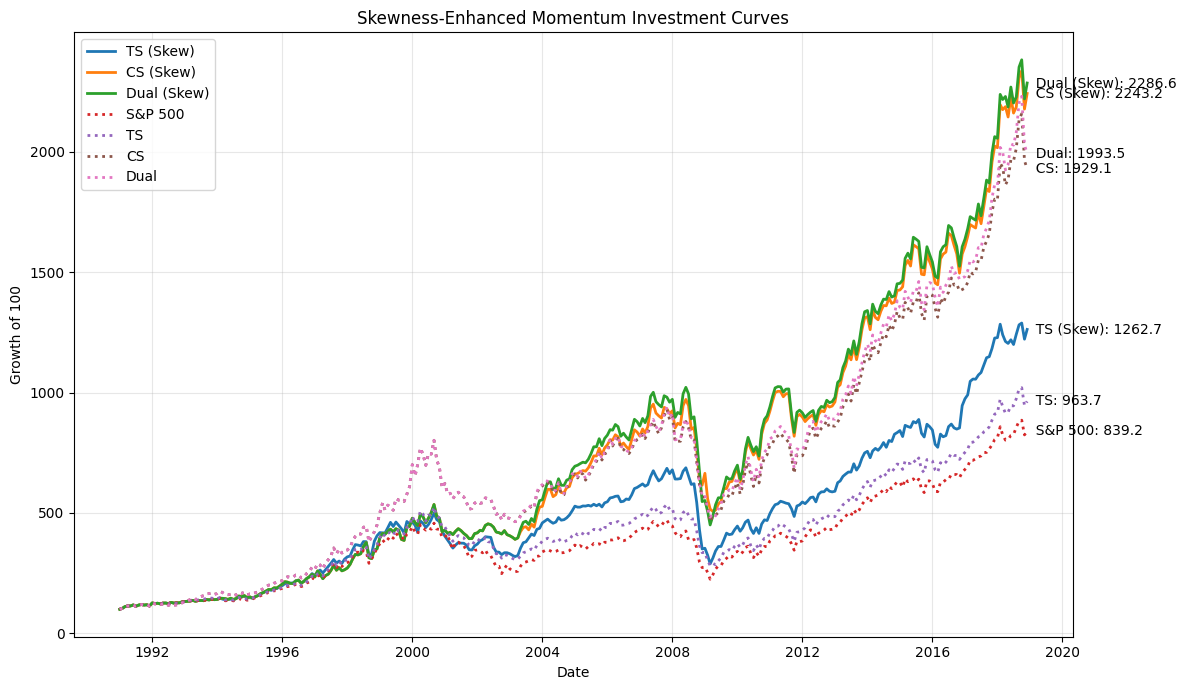

In [124]:
def plot_investment_curves(returns_dict, base=100.0, logy=False, title="Investment (Equity) Curves"):

    # align to common dates where ALL series are available
    df_ret = pd.concat(returns_dict, axis=1)
    if isinstance(df_ret.columns, pd.MultiIndex):
        df_ret.columns = [c[0] if isinstance(c, tuple) else c for c in df_ret.columns]
    df_ret = df_ret.dropna(how="any")
    if df_ret.empty:
        raise ValueError("No overlapping dates across series after alignment.")

    # build equity curves
    eq = base * (1 + df_ret).cumprod()

    # linestyle rule
    def _linestyle(label: str) -> str:
        s = label.lower()
        if "skew" in s:
            return "-"          # skew-enhanced: solid
        if "bench" in s:
            return "-"          # benchmark: solid
        return ":"              # plain (no skew): dotted

    # plot
    plt.figure(figsize=(12, 7))
    for col in eq.columns:
        ls = _linestyle(col)
        plt.plot(eq.index, eq[col], label=col, linestyle=ls, linewidth=2)
        y_last = eq[col].iloc[-1]
        plt.text(eq.index[-1], y_last, f"  {col}: {y_last:.1f}", va='center')

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(f"Growth of {int(base)}")
    if logy:
        plt.yscale("log")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

# ================== USAGE ==================
# 0) Inputs: monthly_checked (prices), weights_checked (weights)
P, W, U, R = prep(monthly_checked, weights_checked)

# 1) Momentum (12–1, trend-following) and availability (skip-1 month)
M  = momentum_k_j(P, k=12, j=1, mode="trend")
AV = availability_k_j(P, k=12, j=1)

# 2) Rolling skewness and skewness quintile (Q1 = most negative skew)
SKEW = rolling_moment_skew(R, window=36)  # proxy for Bali et al. skewness measure, shifted by 1
Q1_LOW_SKEW = skew_quintile_mask(SKEW, U, AV, q=5, which="low", min_obs=24, returns=R)

# 3) Plain momentum selections (TS / CS / Dual)
TS_sel_plain   = ts_mask(M, U, AV, threshold=0.00)   # TS ≥ 0%
CS_sel_plain   = cs_mask(M, U, AV, top_frac=0.20)    # CS top 20%
DUAL_sel_plain = dual_mask(M, U, AV, threshold=0.00, top_frac=0.20)

# 4) Skewness-enhanced selections (Skew first, then momentum within that bucket)
TS_sel_enh   = TS_sel_plain   & Q1_LOW_SKEW         # "negatively skewed winners" long-only analog
CS_sel_enh   = CS_sel_plain   & Q1_LOW_SKEW
DUAL_sel_enh = DUAL_sel_plain & Q1_LOW_SKEW

# 5) Weights (sum to 100) + fallback to benchmark if empty; benchmark = original weights
W_BENCH_ORIG = W
W_TS_plain    = reweight_to_100_with_fallback(W, TS_sel_plain,    W_BENCH_ORIG)
W_CS_plain    = reweight_to_100_with_fallback(W, CS_sel_plain,    W_BENCH_ORIG)
W_DUAL_plain  = reweight_to_100_with_fallback(W, DUAL_sel_plain,  W_BENCH_ORIG)

W_TS_enh      = reweight_to_100_with_fallback(W, TS_sel_enh,      W_BENCH_ORIG)
W_CS_enh      = reweight_to_100_with_fallback(W, CS_sel_enh,      W_BENCH_ORIG)
W_DUAL_enh    = reweight_to_100_with_fallback(W, DUAL_sel_enh,    W_BENCH_ORIG)

# 6) Returns (lagged weights)
r_TS_plain    = portfolio_returns(W_TS_plain,    R, lag=1)
r_CS_plain    = portfolio_returns(W_CS_plain,    R, lag=1)
r_DUAL_plain  = portfolio_returns(W_DUAL_plain,  R, lag=1)

r_TS_enh      = portfolio_returns(W_TS_enh,      R, lag=1)
r_CS_enh      = portfolio_returns(W_CS_enh,      R, lag=1)
r_DUAL_enh    = portfolio_returns(W_DUAL_enh,    R, lag=1)

r_BEN         = portfolio_returns(W_BENCH_ORIG,  R, lag=1)

# 7) Plot: plain vs skewness-enhanced
plot_investment_curves(
    {
        "TS (Skew)": r_TS_enh,
        "CS (Skew)": r_CS_enh,
        "Dual (Skew)": r_DUAL_enh,
        "S&P 500":    r_BEN,
        "TS":   r_TS_plain,
        "CS":   r_CS_plain,
        "Dual": r_DUAL_plain,

    },
    base=100.0, logy=False,
    title="Skewness-Enhanced Momentum Investment Curves"
)

The three **Skewness-Enhanced** strategies compound faster than their plain momentum counterparts and the benchmark. F rom this plot, it seems that filtering by skewness meaningfully boosts **Momentum**.


### **4. Holdings per Month**

In [125]:
# ------- holdings counter (weights > 0) -------
def track_holdings(weights_df: pd.DataFrame) -> pd.Series:
    """Count how many assets have strictly positive weights each month."""
    return weights_df.gt(0).sum(axis=1).astype(int)

# --- holdings time series ---
ts_plain_hold   = track_holdings(W_TS_plain)
cs_plain_hold   = track_holdings(W_CS_plain)
dual_plain_hold = track_holdings(W_DUAL_plain)

ts_skew_hold    = track_holdings(W_TS_enh)
cs_skew_hold    = track_holdings(W_CS_enh)
dual_skew_hold  = track_holdings(W_DUAL_enh)

bench_hold      = track_holdings(W_BENCH_ORIG)  # benchmark = original weights

# --- selection counts (to detect non-fallback months) ---
ts_plain_cnt    = TS_sel_plain.sum(axis=1)
cs_plain_cnt    = CS_sel_plain.sum(axis=1)
dual_plain_cnt  = DUAL_sel_plain.sum(axis=1)

ts_skew_cnt     = TS_sel_enh.sum(axis=1)
cs_skew_cnt     = CS_sel_enh.sum(axis=1)
dual_skew_cnt   = DUAL_sel_enh.sum(axis=1)

mask_ts_plain   = ts_plain_cnt  > 0
mask_cs_plain   = cs_plain_cnt  > 0
mask_dual_plain = dual_plain_cnt> 0

mask_ts_skew    = ts_skew_cnt   > 0
mask_cs_skew    = cs_skew_cnt   > 0
mask_dual_skew  = dual_skew_cnt > 0

# Align all dates and build a tidy DataFrame (for display)
holdings_df = pd.concat(
    {
        "TS (Skew)":   ts_skew_hold,
        "CS (Skew)":   cs_skew_hold,
        "Dual (Skew)": dual_skew_hold,
        "TS":          ts_plain_hold,
        "CS":          cs_plain_hold,
        "Dual":        dual_plain_hold,
        "S&P 500":     bench_hold,
    },
    axis=1
).sort_index()

# First date where ALL six strategies are actually live (selected ≥1 asset)
mask_all_live = (mask_ts_plain & mask_cs_plain & mask_dual_plain &
                 mask_ts_skew  & mask_cs_skew  & mask_dual_skew)
if mask_all_live.any():
    first_valid_date = mask_all_live.idxmax()
    holdings_df_filtered = holdings_df.loc[first_valid_date:].copy()
else:
    holdings_df_filtered = holdings_df.copy()

# ---- averages: exclude fallback months for each strategy individually ----
avg_ts_plain   = ts_plain_hold.loc[mask_ts_plain].mean()   if mask_ts_plain.any()   else np.nan
avg_cs_plain   = cs_plain_hold.loc[mask_cs_plain].mean()   if mask_cs_plain.any()   else np.nan
avg_dual_plain = dual_plain_hold.loc[mask_dual_plain].mean() if mask_dual_plain.any() else np.nan

avg_ts_skew    = ts_skew_hold.loc[mask_ts_skew].mean()     if mask_ts_skew.any()    else np.nan
avg_cs_skew    = cs_skew_hold.loc[mask_cs_skew].mean()     if mask_cs_skew.any()    else np.nan
avg_dual_skew  = dual_skew_hold.loc[mask_dual_skew].mean() if mask_dual_skew.any()  else np.nan

avg_bench      = bench_hold.mean()  # benchmark has no fallback condition

avg_counts = {
    "TS (Skew)":   round(avg_ts_skew, 2),
    "CS (Skew)":   round(avg_cs_skew, 2),
    "Dual (Skew)": round(avg_dual_skew, 2),
    "TS":          round(avg_ts_plain, 2),
    "CS":          round(avg_cs_plain, 2),
    "Dual":        round(avg_dual_plain, 2),
    "S&P 500":     round(avg_bench, 2),
}

# Append averages to column names
holdings_df_filtered = holdings_df_filtered.rename(
    columns={col: f"{col} ({avg_counts[col]} assets)" for col in holdings_df_filtered.columns}
)

# Show table (Date as a column)
holdings_table = holdings_df_filtered.reset_index().rename(columns={"index": "Date"})
display(holdings_table)

# Save CSV (Colab/Drive path)
file_path = "/content/gdrive/MyDrive/Data Science/Financial markets analytics/project/number_of_holdings_skew_vs_plain.csv"
holdings_table.to_csv(file_path, index=False)
print(f"Saved to: {file_path}")


,Date,TS (Skew) (51.4 assets),CS (Skew) (14.82 assets),Dual (Skew) (15.02 assets),TS (298.53 assets),CS (93.49 assets),Dual (91.0 assets),S&P 500 (500.62 assets)
0,1994-01-31,54,20,20,313,97,97,500
1,1994-02-28,54,23,23,324,97,97,500
2,1994-03-31,43,21,21,272,96,96,500
3,1994-04-30,45,21,21,251,96,96,500
4,1994-05-31,46,24,24,236,95,95,500
...,...,...,...,...,...,...,...,...
294,2018-07-31,43,13,13,309,96,96,505
295,2018-08-31,49,11,11,346,96,96,505
296,2018-09-30,48,12,12,336,96,96,505
297,2018-10-31,46,11,11,315,96,96,505


Saved to: /content/gdrive/MyDrive/Data Science/Financial markets analytics/project/number_of_holdings_skew_vs_plain.csv


The skewness filter makes portfolios much more concentrated. For example, **TS (Skew)** holds an average of 51 names, while **TS** has a way bigger average of 299.

Because the skewness versions hold far fewer names, they can have **higher stock-specific risk** and **larger tracking error** versus the benchmark and other portfolios.


## **Results Comparison**

In [126]:
def _equity_curve(returns: pd.Series, base=1.0) -> pd.Series:
    r = returns.dropna()
    if r.empty:
        return pd.Series(dtype=float)
    return base * (1 + r).cumprod()

def simple_monthly_metrics(returns: pd.Series, rf_annual: float = 0.0):
    """
    Returns a dict with:
      Avg Monthly Return (%), Monthly Volatility (%), Monthly Sharpe,
      Max Drawdown (%), Win Rate (%)
    """
    eq = _equity_curve(returns, base=1.0)
    if eq.empty:
        return {k: np.nan for k in [
            "Avg Monthly Return (%)","Monthly Volatility (%)","Monthly Sharpe",
            "Max Drawdown (%)","Win Rate (%)"
        ]}
    r = returns.loc[eq.index].dropna()
    avg_m = r.mean()
    vol_m = r.std()
    rf_m  = (1 + rf_annual)**(1/12) - 1
    sharpe_m = (avg_m - rf_m) / vol_m if vol_m and vol_m > 0 else np.nan

    dd = (eq / eq.cummax() - 1).min()
    win_rate = (r > 0).mean() * 100.0

    return {
        "Avg Monthly Return (%)": 100 * avg_m,
        "Monthly Volatility (%)": 100 * vol_m,
        "Monthly Sharpe":         sharpe_m,
        "Max Drawdown (%)":       100 * dd,
        "Win Rate (%)":           win_rate
    }

# ---- choose the lines you want to compare (edit as needed) ----
series_map = {
    "TS":           r_TS_plain,
    "TS Skew":         r_TS_enh,
    "CS":           r_CS_plain,
    "CS Skew":         r_CS_enh,
    "Dual":         r_DUAL_plain,
    "Dual Skew":       r_DUAL_enh,
    "S&P 500": r_BEN,
}

# build and display the table
summary_simple = pd.DataFrame({k: simple_monthly_metrics(v, rf_annual=0.0) for k, v in series_map.items()}).T
summary_simple = summary_simple.round({
    "Average Monthly Return (%)": 2,
    "Monthly Volatility (%)": 2,
    "Monthly Sharpe": 3,
    "Max Drawdown (%)": 2,
    "Win Rate (%)": 2
})
display(summary_simple)

,Avg Monthly Return (%),Monthly Volatility (%),Monthly Sharpe,Max Drawdown (%),Win Rate (%)
TS,0.748261,3.77,0.198,-47.48,64.88
TS Skew,0.846205,4.18,0.203,-58.06,62.80
CS,0.985774,4.49,0.219,-50.17,62.50
CS Skew,1.033275,4.54,0.228,-47.94,60.12
Dual,0.995453,4.49,0.222,-48.62,62.50
Dual Skew,1.044733,4.65,0.224,-55.94,60.12
S&P 500,0.716270,4.01,0.179,-52.25,64.29


**Key Takeaways**

- **CS (Skew)** delivers the highest Sharpe Ratio in the table.
- All **Skewness-Enhanced portfolios** strategies generally show a higher Sharpe Ratio than the benchmark and Momentum portfolios.
- Both returns and volatility increases in **Skewness-Enhanced portfolios**.

## **Assets Division by Capitalization**

Companies are ranked by weight at a specific date (from smallest to largest), then grouped as follows:

1. **Small-Cap**: bottom 20% → the 20% of firms with the smallest weights  
2. **Mid-Cap**: next 30% → firms ranked from the 20th to the 50th percentile  
3. **Large-Cap**: top 50% → the 50% of firms with the largest weights

Even though all firms in the S&P 500 are large in absolute size, this relative classification helps analyze how investment strategies perform across different size segments within the index.      

In [127]:
# ---------- safer rolling skewness (avoids All-NaN slice warnings) ----------
def rolling_moment_skew_safe(R: pd.DataFrame, window=36):
    cnt  = R.rolling(window=window, min_periods=window).count().shift(1)
    skew = R.rolling(window=window, min_periods=window).skew().shift(1)
    valid = cnt >= window
    return skew.where(valid), valid

# ---------- cap buckets from weights (dynamic by default) ----------
def cap_groups_from_weights(W: pd.DataFrame, U: pd.DataFrame, p_small=0.20, p_mid=0.50, method="dynamic", ref_date=None):
    if method == "dynamic":
        pct = W.where(U).rank(axis=1, method='first', ascending=True, pct=True)
        small = (pct <= p_small) & U
        mid   = (pct > p_small) & (pct <= p_mid) & U
        large = (pct > p_mid) & U
    else:
        if ref_date is None: ref_date = W.index.max()
        w_row = W.loc[ref_date].where(W.loc[ref_date] > 0)
        pct = w_row.rank(method='first', ascending=True, pct=True)
        small_cols = pct.index[pct <= p_small]
        mid_cols   = pct.index[(pct > p_small) & (pct <= p_mid)]
        large_cols = pct.index[pct > p_mid]
        small = U.mul(False); mid = U.mul(False); large = U.mul(False)
        if len(small_cols): small.loc[:, small_cols] = U.loc[:, small_cols]
        if len(mid_cols):   mid.loc[:,   mid_cols]   = U.loc[:,   mid_cols]
        if len(large_cols): large.loc[:, large_cols] = U.loc[:, large_cols]
        small = small.astype(bool); mid = mid.astype(bool); large = large.astype(bool)
    return {"Small": small, "Mid": mid, "Large": large}

/usr/local/lib/python3.12/dist-packages/pandas/core/window/rolling.py:611: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.12/dist-packages/pandas/core/window/rolling.py:611: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.12/dist-packages/pandas/core/window/rolling.py:611: RuntimeWarning:

All-NaN slice encountered



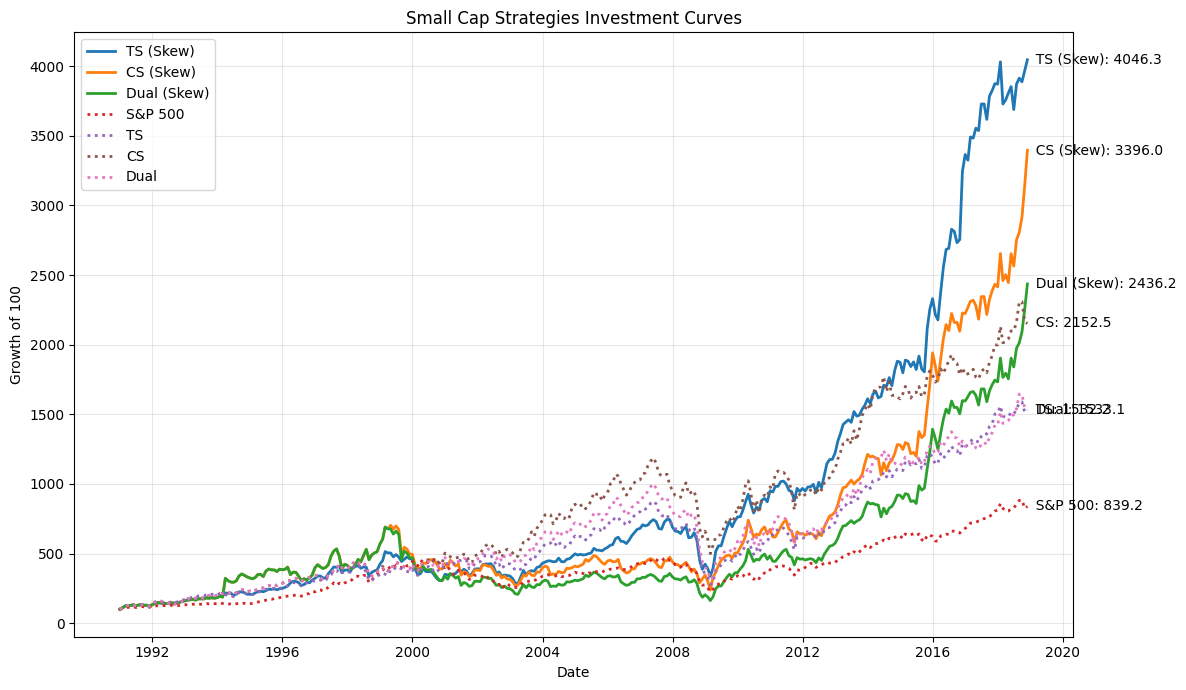

#### Small Cap — Monthly Statistics (5 metrics)

,Average Monthly Return (%),Monthly Volatility (%),Monthly Sharpe,Max Drawdown (%),Win Rate (%)
TS (Skew),1.26,5.61,0.225,-54.78,59.82
TS,0.95,5.10,0.186,-68.41,61.31
CS (Skew),1.34,7.84,0.171,-66.15,56.55
CS,1.06,5.32,0.199,-57.97,60.71
Dual (Skew),1.24,7.85,0.158,-76.50,55.65
Dual,0.97,5.58,0.174,-68.52,60.42
S&P 500,0.72,4.01,0.179,-52.25,64.29


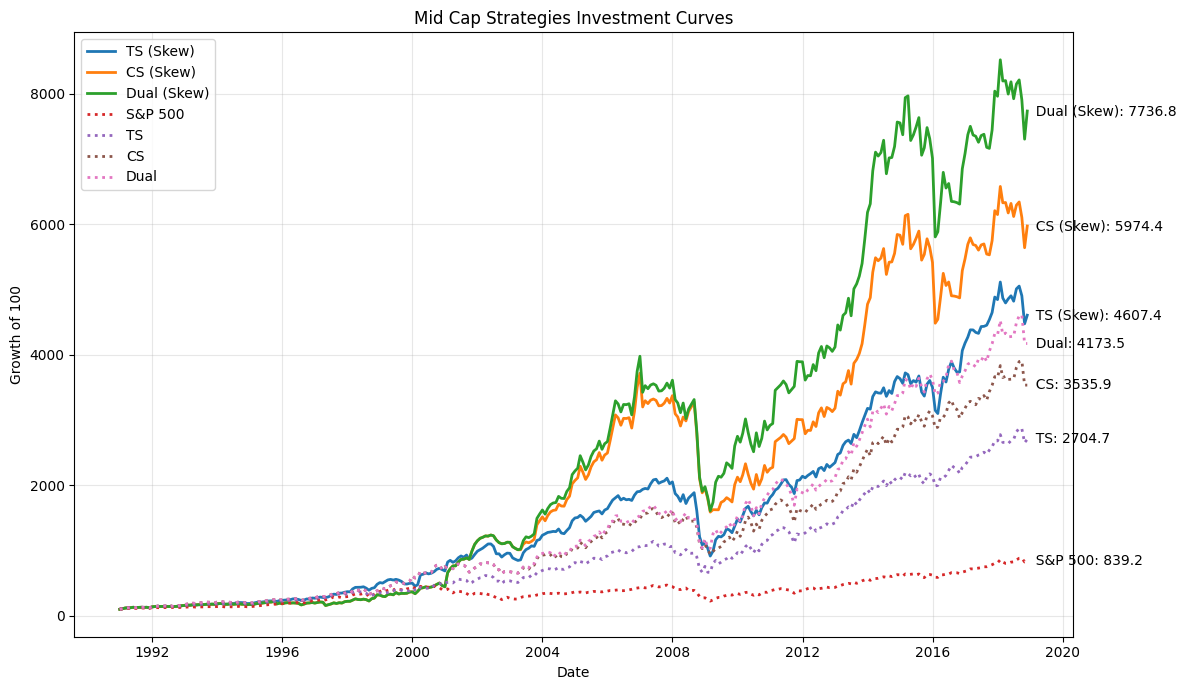

#### Mid Cap — Monthly Statistics (5 metrics)

,Average Monthly Return (%),Monthly Volatility (%),Monthly Sharpe,Max Drawdown (%),Win Rate (%)
TS (Skew),1.26,4.78,0.263,-56.58,65.18
TS,1.07,4.21,0.255,-41.89,63.69
CS (Skew),1.41,6.20,0.228,-57.25,62.50
CS,1.17,4.58,0.256,-42.85,64.29
Dual (Skew),1.50,6.31,0.237,-59.57,63.10
Dual,1.23,4.80,0.257,-38.98,63.99
S&P 500,0.72,4.01,0.179,-52.25,64.29


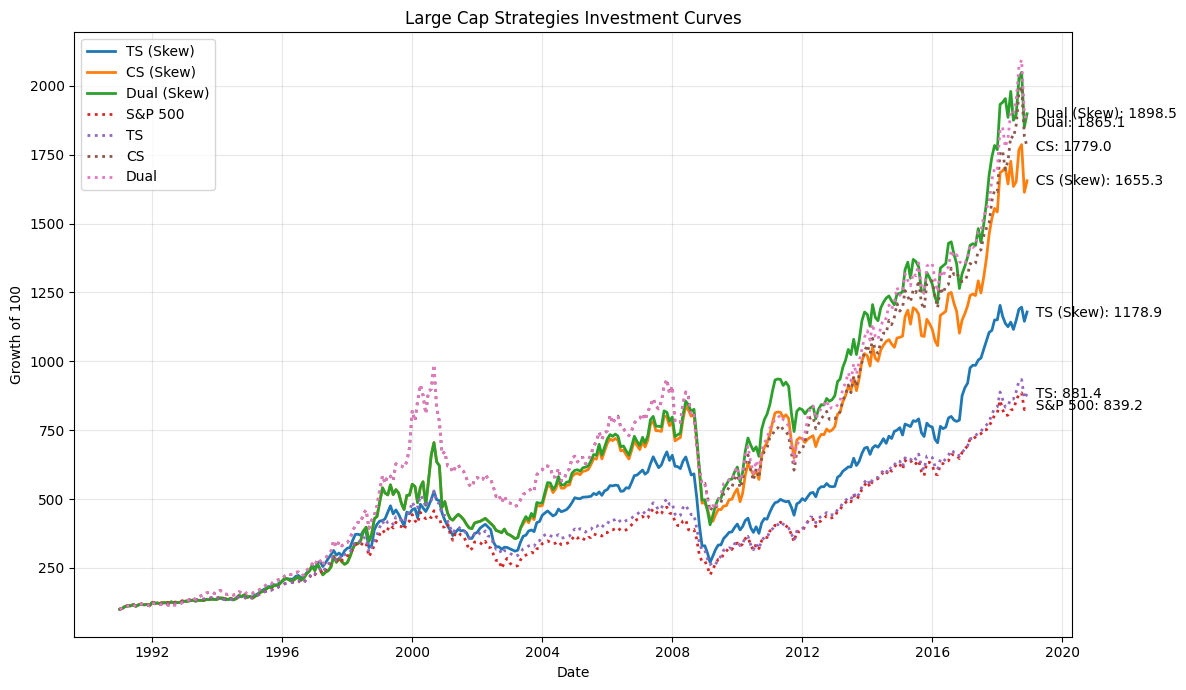

#### Large Cap — Monthly Statistics (5 metrics)

,Average Monthly Return (%),Monthly Volatility (%),Monthly Sharpe,Max Drawdown (%),Win Rate (%)
TS (Skew),0.83,4.31,0.193,-59.77,62.80
TS,0.72,3.79,0.190,-50.46,63.99
CS (Skew),0.98,5.25,0.186,-49.93,59.23
CS,0.98,4.83,0.202,-53.79,62.50
Dual (Skew),1.02,5.32,0.192,-52.47,59.82
Dual,0.99,4.83,0.205,-53.16,62.50
S&P 500,0.72,4.01,0.179,-52.25,64.29


In [128]:
# ---------- simple monthly metrics (your 5 stats) ----------
def _equity_curve(returns: pd.Series, base=1.0) -> pd.Series:
    r = returns.dropna()
    return pd.Series(dtype=float) if r.empty else base * (1 + r).cumprod()

def simple_monthly_metrics(returns: pd.Series, rf_annual: float = 0.0):
    eq = _equity_curve(returns, base=1.0)
    if eq.empty:
        return {k: np.nan for k in ["Average Monthly Return (%)","Monthly Volatility (%)","Monthly Sharpe","Max Drawdown (%)","Win Rate (%)"]}
    r = returns.loc[eq.index].dropna()
    avg_m = r.mean()
    vol_m = r.std()
    rf_m  = (1 + rf_annual)**(1/12) - 1
    sharpe_m = (avg_m - rf_m) / vol_m if vol_m and vol_m > 0 else np.nan
    dd = (eq / eq.cummax() - 1).min()
    win_rate = (r > 0).mean() * 100.0
    return {"Average Monthly Return (%)":100*avg_m, "Monthly Volatility (%)":100*vol_m, "Monthly Sharpe":sharpe_m, "Max Drawdown (%)":100*dd, "Win Rate (%)":win_rate}

# ---------- run strategies inside a bucket (global benchmark used only for plotting/table) ----------
def run_bucket_strategies(bucket_mask: pd.DataFrame,
                          P: pd.DataFrame, W: pd.DataFrame, U: pd.DataFrame, R: pd.DataFrame,
                          skew_window=36, ts_threshold=0.00, cs_top_frac=0.20, k=12, j=1, mom_mode="trend"):
    # momentum + availability
    M  = momentum_k_j(P, k=k, j=j, mode=mom_mode)
    AV = availability_k_j(P, k=k, j=j)

    # selections within bucket
    TS_sel   = ts_mask(M, U & bucket_mask, AV, threshold=ts_threshold)
    CS_sel   = cs_mask(M, U & bucket_mask, AV, top_frac=cs_top_frac)
    DUAL_sel = TS_sel & CS_sel

    # skew Q1 within bucket (safe)
    SKEW, skew_ok = rolling_moment_skew_safe(R, window=skew_window)
    scope  = (U & bucket_mask & AV & skew_ok & SKEW.notna())
    pct_sk = SKEW.where(scope).rank(axis=1, method='first', ascending=True, pct=True)
    SKEW_Q1 = pct_sk <= 0.20

    TS_sel_enh   = TS_sel   & SKEW_Q1
    CS_sel_enh   = CS_sel   & SKEW_Q1
    DUAL_sel_enh = DUAL_sel & SKEW_Q1

    # bucket benchmark (for fallback only)
    W_BUCKET_BENCH = reweight_to_100_with_fallback(W, bucket_mask, W)  # sums ~100 inside bucket

    # strategy weights (sum 100) with fallback to BUCKET benchmark if empty
    W_TS       = reweight_to_100_with_fallback(W, TS_sel,       W_BUCKET_BENCH)
    W_CS       = reweight_to_100_with_fallback(W, CS_sel,       W_BUCKET_BENCH)
    W_DUAL     = reweight_to_100_with_fallback(W, DUAL_sel,     W_BUCKET_BENCH)
    W_TS_enh   = reweight_to_100_with_fallback(W, TS_sel_enh,   W_BUCKET_BENCH)
    W_CS_enh   = reweight_to_100_with_fallback(W, CS_sel_enh,   W_BUCKET_BENCH)
    W_DUAL_enh = reweight_to_100_with_fallback(W, DUAL_sel_enh, W_BUCKET_BENCH)

    # returns (lagged) — renamed to your preferred labels
    return {
        "TS (Skew)"  : portfolio_returns(W_TS_enh,   R, lag=1),
        "CS (Skew)"  : portfolio_returns(W_CS_enh,   R, lag=1),
        "Dual (Skew)": portfolio_returns(W_DUAL_enh, R, lag=1),
        "TS"         : portfolio_returns(W_TS,       R, lag=1),
        "CS"         : portfolio_returns(W_CS,       R, lag=1),
        "Dual"       : portfolio_returns(W_DUAL,     R, lag=1),
    }

# ================== RUN ==================
# 0) Prep (prices = monthly_checked, weights = weights_checked)
P, W, U, R = prep(monthly_checked, weights_checked)

# 1) Global benchmark (original index weights, unchanged)
r_BEN = portfolio_returns(W, R, lag=1)

# 2) Build cap buckets and run strategies inside each bucket
cap_masks = cap_groups_from_weights(W, U, p_small=0.20, p_mid=0.50, method="dynamic")
results_by_bucket = {
    b: run_bucket_strategies(mask, P, W, U, R, skew_window=36, ts_threshold=0.00, cs_top_frac=0.20, k=12, j=1, mom_mode="trend")
    for b, mask in cap_masks.items()
}

# --- desired orders ---
_plot_order = ["TS (Skew)", "CS (Skew)", "Dual (Skew)", "S&P 500", "TS", "CS", "Dual"]
_row_order  = ["TS (Skew)", "TS", "CS (Skew)", "CS", "Dual (Skew)", "Dual", "S&P 500"]

# 3) & 4) For each bucket: plot + table right underneath
for bucket in ["Small", "Mid", "Large"]:
    # build dict for this bucket + GLOBAL benchmark
    rdict = results_by_bucket[bucket].copy()
    rdict["S&P 500"] = r_BEN

    # PLOT in the exact order requested
    rdict_plot = {name: rdict[name] for name in _plot_order if name in rdict}
    plot_investment_curves(
        rdict_plot,
        base=100.0, logy=False,
        title=f"{bucket} Cap Strategies Investment Curves"
    )

    # TABLE (5 stats) in the exact order requested
    rows = {name: simple_monthly_metrics(rdict[name], rf_annual=0.0)
            for name in _row_order if name in rdict}

    df_bucket = pd.DataFrame(rows).T.reindex(_row_order)
    df_bucket = df_bucket[[
        "Average Monthly Return (%)", "Monthly Volatility (%)",
        "Monthly Sharpe", "Max Drawdown (%)", "Win Rate (%)"
    ]].round({
        "Average Monthly Return (%)": 2,
        "Monthly Volatility (%)": 2,
        "Monthly Sharpe": 3,
        "Max Drawdown (%)": 2,
        "Win Rate (%)": 2
    })

    display(Markdown(f"#### {bucket} Cap — Monthly Statistics (5 metrics)"))
    display(df_bucket)
    # Optional save:
    df_bucket.to_csv(f"/content/gdrive/MyDrive/Data Science/Financial markets analytics/project/{bucket.lower()}_cap_stats.csv")

**1. Small Cap**

- **Winners**: **Skewness-Enhanced** portfolios again outperform the plain versions, with especially strong separation for **TS** (0.225 of Sharoe Ratio for Skewness-Enhanced TS versus 0.186 for plain TS).

- **Takeaway**: The skewness filter adds clear value across momentum styles in the mid-cap universe.

**2. Mid Cap**

- **Winners**: All three **Skewness-enhanced** versions, especially **Dual** dominate their plain counterparts and the index.

- **Takeaway**: The effect is most pronounced here—terminal wealth gaps are wide.

**3. Large Cap**

- **Winners**: **Dual** and **TS** (both Plain and Skewness-Enhanced versions) finish clearly above the **Benchmark** and **TS** portfolios.

- **Takeaway**: Skewness is not determining as in the previous groups, but for **TS** Skewness-Enhanced portfolio perform way better than the plain one.

## **Conclusions and Final Considerations**

- **Overall Summary**\
Across the S&P 500 universe, adding a simple **Skewness** filter to **Momentum**, generally, **improves** both total return and Sharpe Ratio versus plain Momentum and the S&P 500 index.

- **Less Diversification**\
**Skewness** portfolios hold far **fewer names**. That concentration raises idiosyncratic risk and tracking error, even if Sharpe improves.

- **Costs & Turnover**:\
**Momentum and Skewness** seem to be be game changers, anyway more **realistic details**, such as transaction costs and liquidity constraints, should be took in count.

- **Capitalization Groups**:\
Dividing the index in capitalization groups highlights different Momentum and Skewness behaviours between firms of different sizes.